# Bridging the gap between binary image (segmentation) and analysis


The current version of the Allen Cell Segmenter is primarily focusing on converting fluorescent images into binary images, i.e., the mask of the target structures separated from the background (a.k.a segmentation). But, the binary images themselves are not always useful, with perhaps the exception of visualization of the entire image, until they are converted into statistically sound numbers that are then used for downstream analysis. Often the desired numbers do not refer to all masked voxels in an entire image but instead to specific “objects” or groups of objects within the image. In our python package, we provide functions to bridge the gap between binary segmentation and downstream analysis via  object identification. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage
from aicssegmentation.cli.to_analysis import simple_builder, masked_builder
from itkwidgets import view

## Load the binary image generated by segmenter (i.e. structure segmentation result)

In [2]:
structure_seg_reader = AICSImage('../demo_data/TOMM20_pipeline_example_structure_segmentation.tiff')
structure_seg = structure_seg_reader.data[0,0,0,:,:,:]

## Method 1: `simply_builder`

#### Simply convert the binary image into individual analyzable objects

This is useful when you want to get some whole FOV meansurements

#### instuction:

`obj_simple = simple_builder(structure_seg)`

The output `obj_simple` is an image with the same size as input binary image. But, each individual objects are labeled as a unique integer value.

or

`obj_simple, obj_simple_df = simple_builder(structure_seg, return_dataframe=True)`

The output `obj_simple` is the same as above, but, a pre-built dataframe is return, ready for your analysis

In [3]:
# only getting the label image
obj_simple = simple_builder(structure_seg)

In [4]:
# get the number of objects
print(obj_simple.max())

779


In [5]:
# calculat the volume of object 76
print(np.count_nonzero(obj_simple==76))

214


In [6]:
# getting both the label image and the pre-built dataframe
obj_simple, obj_simple_df = simple_builder(structure_seg, return_dataframe=True)

In [7]:
# calculate the volume of each object and report the average and standard diviation
obj_simple_df = obj_simple_df.assign(vol="")
for index, row in obj_simple_df.iterrows():
    obj_index = int(row['object_index'])
    vol = np.count_nonzero(obj_simple==obj_index)
    obj_simple_df.loc[index, 'vol'] = vol

In [8]:
# do some statistics

# sum
print(obj_simple_df.vol.sum())

# average
print(obj_simple_df.vol.mean())

# standard deviation
print(obj_simple_df.vol.std())

# min
print(obj_simple_df.vol.min())

# max
print(obj_simple_df.vol.max())

1242703
1595.2541720154043
6364.78396167209
10
63787


## Method 2: `masked_builder`

#### Convert the binary image into separated groups of analyzable objects according to mask labels

**What is a mask label? Depending on the biological questions, the mask label may vary. It could be areas enclosed by each individual cell or each individual nucleus, or any other way you may want to partition the image into different analyzable regions. All the objects in one particular cell/nucleus/customized region within in the structure segmentation binary image would have the same group id.**


This is useful, for example, when a per-cell measurement is needed. In this case a cell segmentation is used as the mask label.

*Note: In this demo, we are using a cell segmentation generated by a deep learning based segmentation algorithm developed at the Allen Institute for Cell Science. We are working on the release of our nuclear/cell segmentation workflows. Please stay tuned :) For your data, you may use your own nuclear/cell segmentation approach or you can do this via manual annotation in Fiji*

#### instruction:

`obj_label, obj_df= masked_builder(structure_seg, cell_seg)`

The output `obj_label` is an image with the same size as input binary image. But, each individual objects are labeled as a unique integer value. `obj_df` is a dataframe with two-level indexing: "mask_id" and "obj_id". The "obj_id" corresponds to the unique integer values in `obj_label`. "mask_id" corresponds to each individual cell in the cell segmentaiton. The volume of each individual object is pre-calculated by default and returned together with the dataframe


In [9]:
cell_seg_reader = AICSImage('../demo_data/TOMM20_pipeline_example_cell_segmentation.tiff')
cell_seg = cell_seg_reader.data[0,0,0,:,:,:]

In [10]:
obj_label, obj_df = masked_builder(structure_seg, cell_seg)

In [11]:
obj_df.head()

vol
mask_id obj_id     
1       1       101
        2        55
        3       257
        4        83
        5       387

In [12]:
# get the number of groups/cells
number_of_cells = len(obj_df.index.unique(level='mask_id'))
print(number_of_cells)

13


In [13]:
df_per_cell = []

for index, one_group in obj_df.groupby('mask_id'):
    cell_index = one_group.index.get_level_values('mask_id')[0]
    cell_vol = np.count_nonzero(cell_seg==cell_index)
    df_per_cell.append({
        "cell_index": cell_index,
        "cell_vol":cell_vol,
        "structure_vol_total":one_group['vol'].sum(),
        "structure_vol_average":one_group['vol'].mean(),
        "structure_vol_std":one_group['vol'].std(),
        "structure_number_of_pieces":one_group['vol'].count(),
    })
    
df_per_cell = pd.DataFrame(df_per_cell)

In [14]:
df_per_cell.head()

,cell_index,cell_vol,structure_vol_total,structure_vol_average,structure_vol_std,structure_number_of_pieces
0,1,715281,45141,465.371134,3214.156656,97
1,2,723888,53901,2073.115385,9035.658547,26
2,3,488106,24797,413.283333,1345.903592,60
3,4,668345,59627,1104.203704,5354.951764,54
4,5,489326,32849,556.762712,2440.069610,59


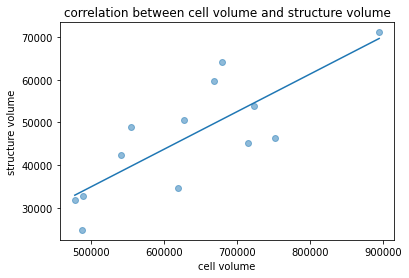

In [15]:
# look at the correlation between structure volume and cell volume

plt.scatter(df_per_cell.cell_vol, df_per_cell.structure_vol_total, marker='o', alpha=0.5)
plt.title('correlation between cell volume and structure volume')
plt.xlabel('cell volume')
plt.ylabel('structure volume')
plt.plot(np.unique(df_per_cell.cell_vol), np.poly1d(np.polyfit(df_per_cell.cell_vol, df_per_cell.structure_vol_total, 1))(np.unique(df_per_cell.cell_vol)))
plt.show()

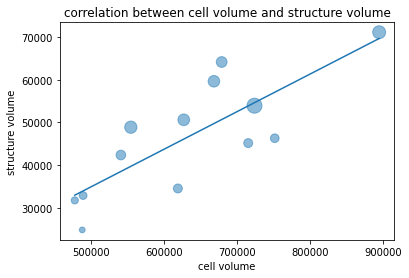

In [16]:
# how is the strucure volume standard deviation correlated to the above plot? We can code it into marker size

plt.scatter(df_per_cell.cell_vol, df_per_cell.structure_vol_total, marker='o', alpha=0.5, s=0.025*df_per_cell.structure_vol_std)
plt.title('correlation between cell volume and structure volume')
plt.xlabel('cell volume')
plt.ylabel('structure volume')
plt.plot(np.unique(df_per_cell.cell_vol), np.poly1d(np.polyfit(df_per_cell.cell_vol, df_per_cell.structure_vol_total, 1))(np.unique(df_per_cell.cell_vol)))
plt.show()


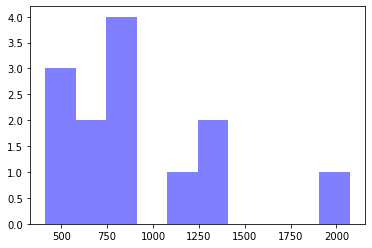

In [17]:
# explore the distribution of average structure volume in each cell
num_bins=10
n, bins, patches = plt.hist(df_per_cell.structure_vol_average, num_bins, facecolor='blue', alpha=0.5)
plt.show()